# Demo No. 1 - Light curve fitting of spotty binaries.

This demo will guide you trough basic principles of fitting spots on the surface of eclipsing binaries.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import os

import astropy.units as u

from elisa.conf import config
from elisa.analytics import LCData, LCBinaryAnalyticsTask
from elisa.analytics.params.parameters import BinaryInitialParameters


# setting up a custom logging config to prevent unreasonably long log messages during fit
config.LOG_CONFIG ='jupyter_fit_logging.json'
config.set_up_logging() 

This demo will demonstrate the spot fitting capability on the example of RT LMi `cite source`. As usual, lets load the observations to our `DatraSet` structures:

In [2]:
lcBfile = 'demo_data/lc_data/RTLMi_B.dat'
lcVfile = 'demo_data/lc_data/RTLMi_V.dat'
lcRfile = 'demo_data/lc_data/RTLMi_R.dat'
lcIfile = 'demo_data/lc_data/RTLMi_I.dat'
zero_mag = 11.35
time_unit = u.d
flux_unit = u.mag

lcB = LCData.load_from_file(filename=lcBfile, x_unit=time_unit, y_unit=flux_unit, reference_magnitude=zero_mag)
lcV = LCData.load_from_file(filename=lcVfile, x_unit=time_unit, y_unit=flux_unit, reference_magnitude=zero_mag)
lcR = LCData.load_from_file(filename=lcRfile, x_unit=time_unit, y_unit=flux_unit, reference_magnitude=zero_mag)
lcI = LCData.load_from_file(filename=lcIfile, x_unit=time_unit, y_unit=flux_unit, reference_magnitude=zero_mag)

followed by defining of our `AnalyticsTask` instance. 

In [5]:
task = LCBinaryAnalyticsTask(data={
    'Generic.Bessell.B': lcB,
    'Generic.Bessell.V': lcV,
    'Generic.Bessell.R': lcR,
    'Generic.Bessell.I': lcI
}, method='mcmc', expected_morphology="over-contact")

Make sure that `light_curve` argument keys - passband names are identical to passband names accesible for your Elisa install:

In [6]:
config.PASSBANDS

['bolometric',
 'Generic.Bessell.U',
 'Generic.Bessell.B',
 'Generic.Bessell.V',
 'Generic.Bessell.R',
 'Generic.Bessell.I',
 'SLOAN.SDSS.u',
 'SLOAN.SDSS.g',
 'SLOAN.SDSS.r',
 'SLOAN.SDSS.i',
 'SLOAN.SDSS.z',
 'Generic.Stromgren.u',
 'Generic.Stromgren.v',
 'Generic.Stromgren.b',
 'Generic.Stromgren.y',
 'Kepler',
 'GaiaDR2',
 'TESS']

Suppose, that we already performed light curve fitting using binary model without spots. Lets load the fitted parameters:

In [7]:
task.load_result('demo_data/aux/RT_LMi_lc_lstsqr.json')
task.fit_summary()


BINARY SYSTEM
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            0.362                   -                   -                        Fixed                                             
Semi major axis (a):                               2.641                   -                   -              solRad    2.6265959 / sin(radians(system@inclination))      
Inclination (i):                                    84.0                   -                   -                 deg    Variable                                          
Eccentricity (e):                                    0.0                   -                   -                        Fixed                                             
Arg

Now we can visualize the result (`data_frac_to_normalize` parameter describes how big portion of the observational data should be used for normalization to reduce the effect of the outliers. Fitting procedure itself uses different normalization approach where the effects of uotliers are reduced by default.):

<IPython.core.display.Javascript object>


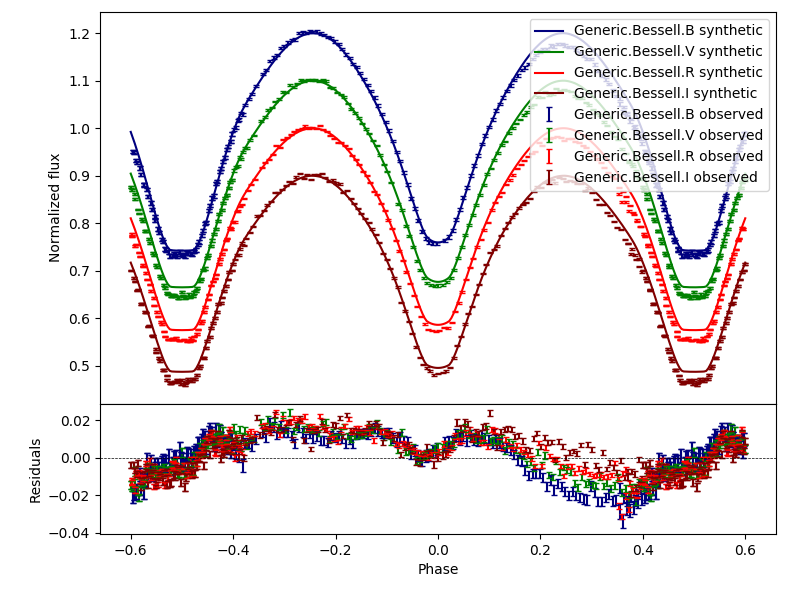

In [8]:
task.plot.model(data_frac_to_normalize=0.05)

As you can see, the shape of the lightcurve is significantly infulenced by the presence of the surface inhomogeneities which we will try to model as stellar spots.

We will now investigate whether the light curve asymmetry can be explained by the presence of cold spot on the far side of primary component. We will now define initial parameter dictionary of spots for primary component where each spot should be named uniquely using `label` keyword argument for each spot. Name of the spot should be unique globally (i.e. there cannot be a spot on the secondary component with the same name):

In [9]:
p_spots = [{
    'label': 'spot1',
    'longitude': {
        'value': 230,
        'fixed': False,
        'min': 180,
        'max': 270,
        'unit': u.degree
    },
    'latitude': {
        'value': 45,
        'fixed': False,
        'min': 0,
        'max': 90,
        'unit': u.degree
    },
    'angular_radius': {
        'value': 50,
        'fixed': False,
        'min': 45,
        'max': 80,
        'unit': u.degree
    },
    'temperature_factor': {
        'value': 0.98,
        'fixed': False,
        'min': 0.93,
        'max': 1.00,
    }
}]

Fitted spot parameter can be also used in a constraint statement in `component@spot@spot_label@spot_parameter` format. We can now expand our parameter dictionary to include one spot on the surface of the primary component:

In [10]:
result = task.get_result()  # retrieving pre-calculated parameters from clear system
result['primary']['spots'] = p_spots

lc_params = BinaryInitialParameters(**result)

Finally, we can try to use MCMC sampler to determine the best fitting parameters for our spot:

In [13]:
param_file = 'demo_data/aux/RT_LMi_spot_fit_params.json'
chain_file = 'demo_data/aux/RT_LMi_spot_fit.json'

# task.fit(x0=lc_params, nsteps=100, nwalkers=100, burn_in=0,
#          discretization=8, interp_treshold=150, progress=True, fit_id=chain_file, save=True)
# task.save_result(param_file)

task.load_chain(chain_file, discard=6000)
task.fit_summary()


BINARY SYSTEM
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            0.362                   -                   -                        Fixed                                             
Semi major axis (a):                               2.633                   -                   -              solRad    2.6265959 / sin(radians(system@inclination))      
Inclination (i):                                    85.9                 0.6                 0.5                 deg    Variable                                          
Eccentricity (e):                                    0.0                   -                   -                        Fixed                                             
Arg

After sampling is finished, the results can be analysed:

<IPython.core.display.Javascript object>


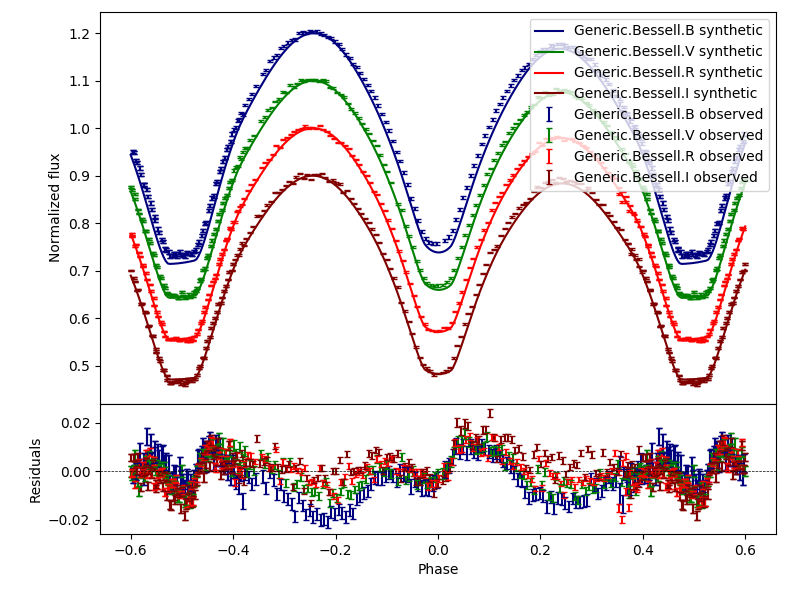

In [14]:
task.plot.model(data_frac_to_normalize=0.05)

<IPython.core.display.Javascript object>


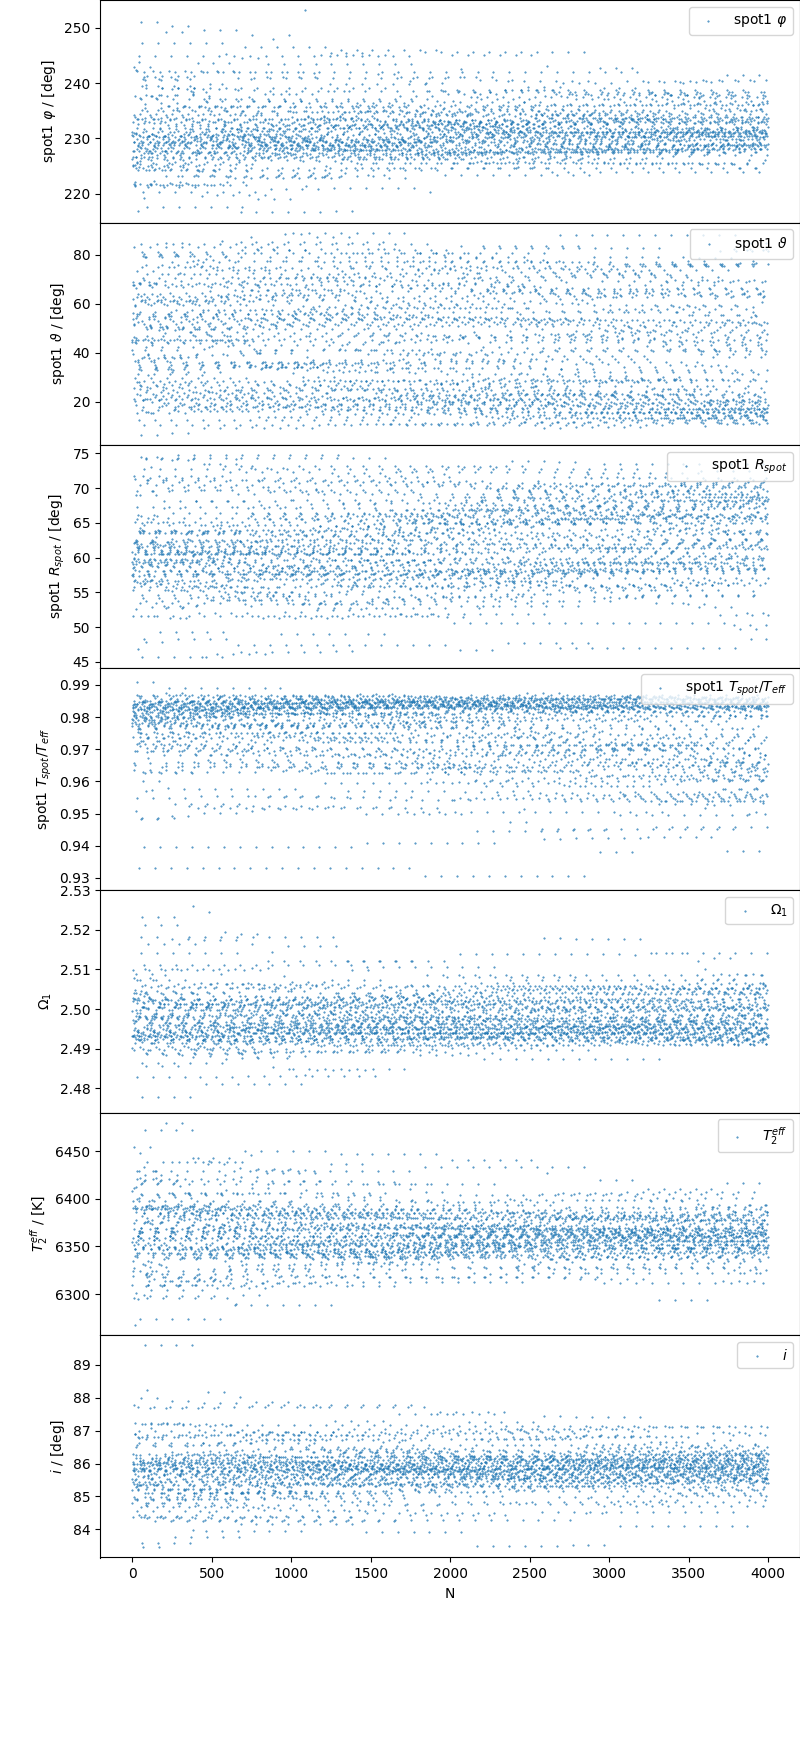

In [15]:
task.plot.traces()

<IPython.core.display.Javascript object>


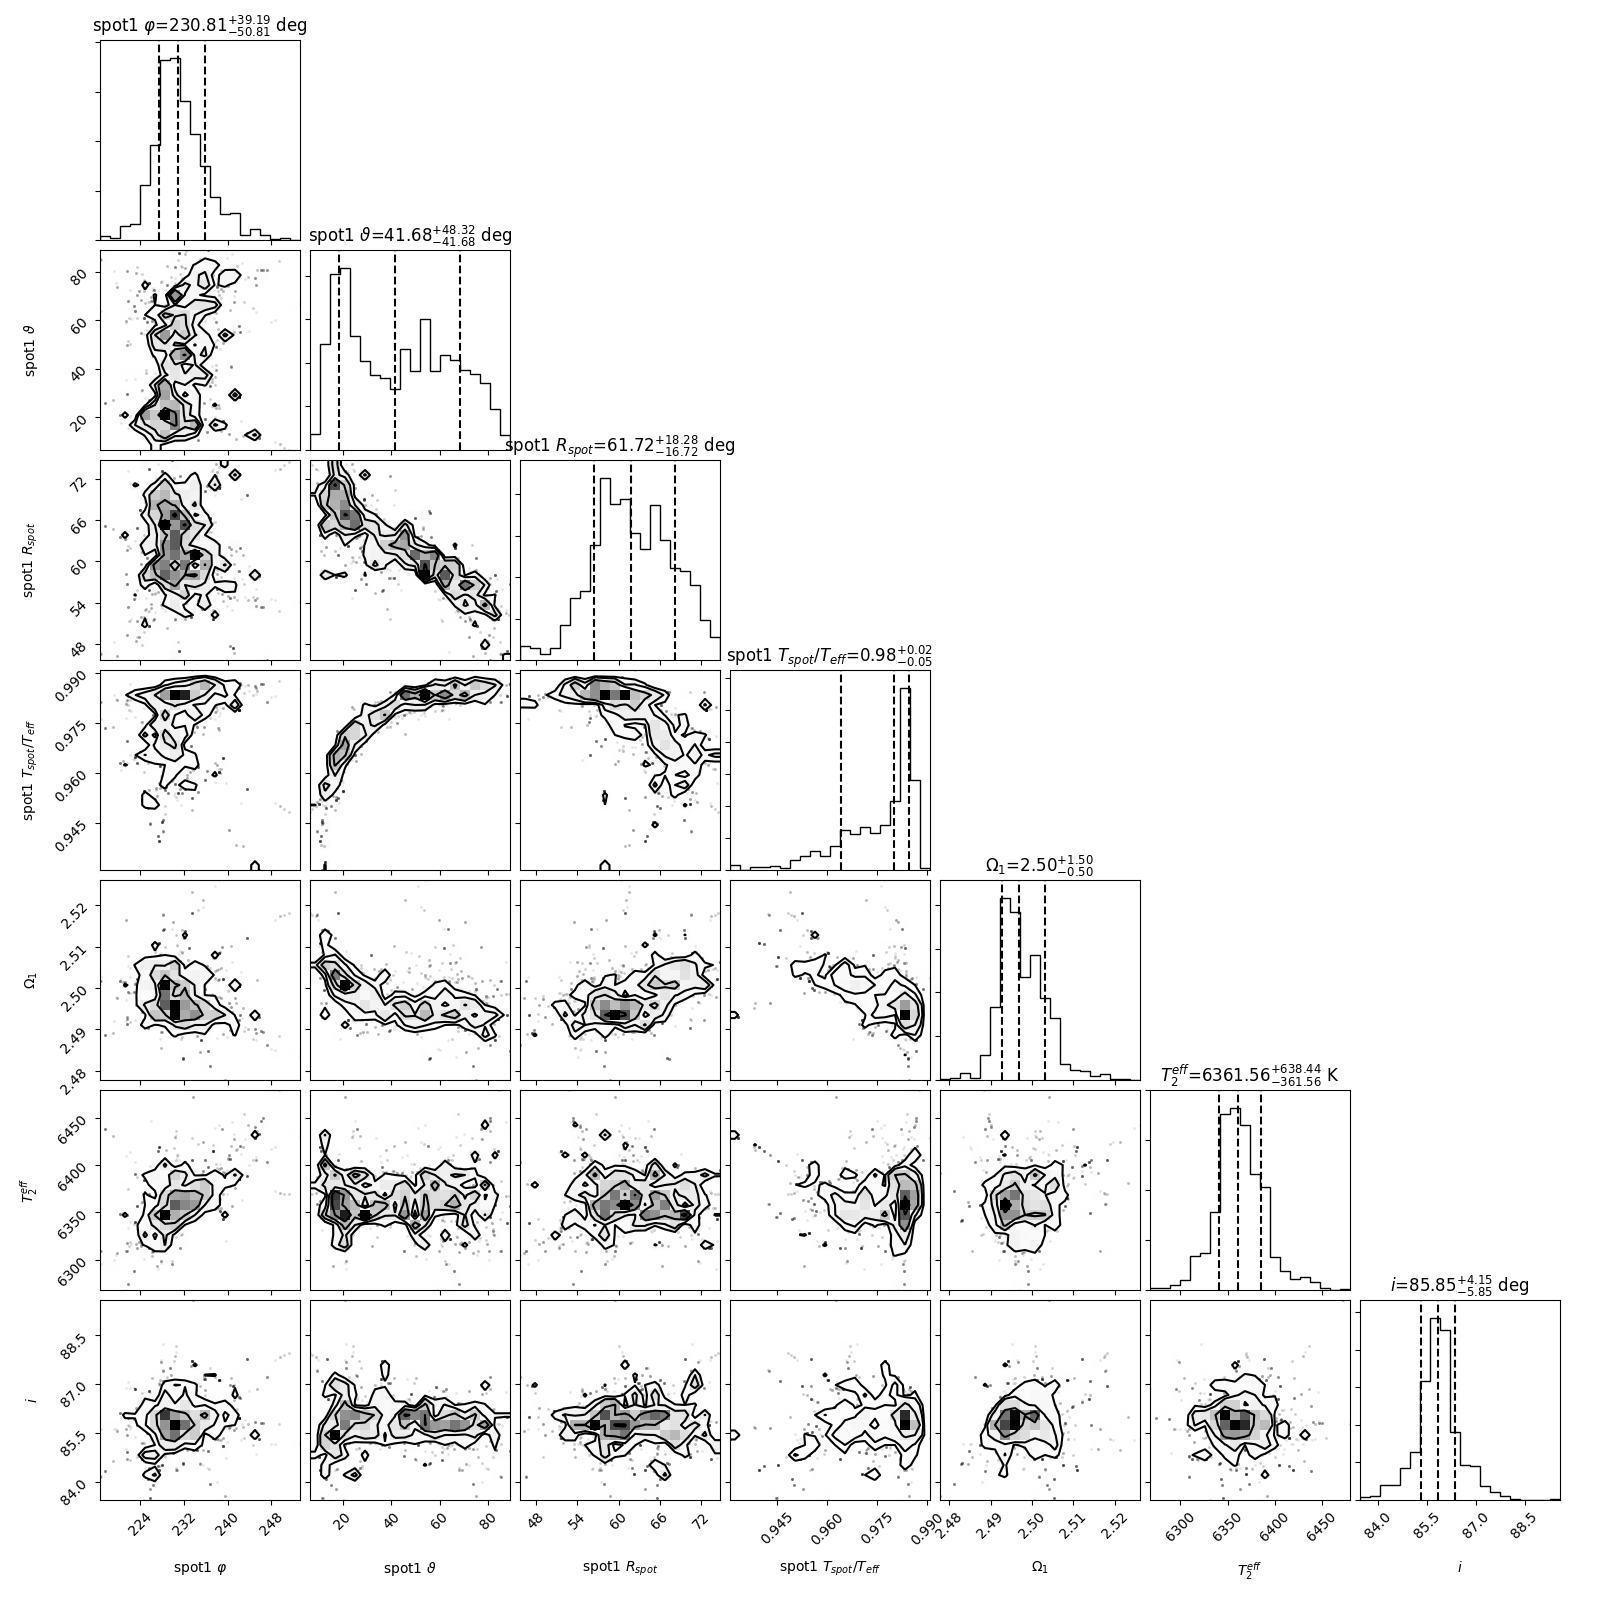

In [16]:
task.plot.corner()

*Note that this demo (as well as the rest of them) is mainly focused on demonstrating the functionality of the package. More extensive sampling is needed to determine the most probable solution for this binary system.